# City altitude Analysis

In [135]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from simpledbf import Dbf5 as db
import numpy as np

## Reading city altitudes dbf

In [136]:
dbf = db("altitude_cities_mg.dbf")
df_altitudes = dbf.to_dataframe()
df_altitudes = df_altitudes.drop(columns=["LAYER","LABEL","codmun2","codmun1"])
df_altitudes = df_altitudes.rename(columns={"RASTERVALU": "Altitude (m)"})
df_altitudes.head()

,NAME,Altitude (m)
0,Cônego Marinho/MG,650
1,Espinosa/MG,566
2,Formoso/MG,844
3,Gameleiras/MG,519
4,Itacarambi/MG,454


## Creating intervals of altitudes

In [137]:
df_altitudes["Altitude"] = pd.cut(x=df_altitudes["Altitude (m)"],bins=[0, 300, 600, 850, 1100, 1500]
                    ,labels=["0-300m","300-600m","600-850m","850-1100m","1100-1500m"])
df_altitudes["NAME"] = df_altitudes["NAME"].replace("\/MG","",regex=True)
df_altitudes = df_altitudes.rename(columns={"Altitude":"Altitude Intervals"})
df_altitudes.head()

,NAME,Altitude (m),Altitude Intervals
0,Cônego Marinho,650,600-850m
1,Espinosa,566,300-600m
2,Formoso,844,600-850m
3,Gameleiras,519,300-600m
4,Itacarambi,454,300-600m


## Counting number of cities per category

In [138]:
labels=["0-300m","300-600m","600-850m","850-1100m","1100-1500m"]
number_of_cities = pd.Series({i:df_altitudes[df_altitudes["Altitude Intervals"]==i]["Altitude (m)"].size for i in labels})
print("Size per category")
print(number_of_cities)

Size per category
0-300m         76
300-600m      206
600-850m      327
850-1100m     214
1100-1500m     30
dtype: int64


## Ploting 

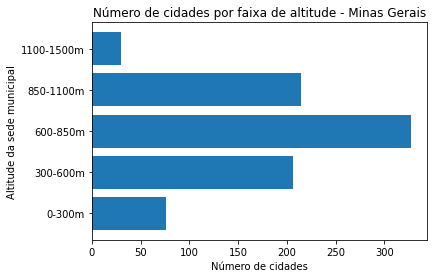

In [139]:
plt.barh(labels,number_of_cities)
plt.title("Número de cidades por faixa de altitude - Minas Gerais")
plt.xlabel('Número de cidades')
plt.ylabel('Altitude da sede municipal')
plt.show()

## Reading CSV with HDI, per capta income etc.

In [140]:
df_idh = pd.read_csv("idh.csv")

In [141]:
wrong_names = df_altitudes[~df_altitudes['NAME'].
    isin(df_idh['Município'])]["NAME"].to_numpy()
correct_names = ["Varjão de Minas","Itabirinha"]
for i in range(len(correct_names)):
    df_altitudes.at[df_altitudes[df_altitudes["NAME"]==wrong_names[i]].index[0],
          "NAME"] = correct_names[i]

In [142]:
df_idh = df_idh.loc[:, ['Município', 'IDHM','Renda per capita','Índice de Gini',
                        'População urbana','População rural','População total']]
df_idh["Rural/Total"] = df_idh['População rural']/df_idh['População total']
df_idh.head()

,Município,IDHM,Renda per capita,Índice de Gini,População urbana,População rural,População total,Rural/Total
0,Abadia dos Dourados,0.689,596.18,0.47,4189,2515,6704,0.375149
1,Abaeté,0.698,707.24,0.54,19704,2986,22690,0.131600
2,Abre Campo,0.654,444.32,0.52,7281,6030,13311,0.453009
3,Acaiaca,0.630,357.03,0.48,2553,1367,3920,0.348724
4,Açucena,0.610,325.42,0.48,4805,5471,10276,0.532406


## Merging DFS

In [143]:
df_idh = df_idh.rename(columns={"Município": "NAME"})
df_altitudes = df_altitudes.merge(df_idh)
df_altitudes.head()

,NAME,Altitude (m),Altitude Intervals,IDHM,Renda per capita,Índice de Gini,População urbana,População rural,População total,Rural/Total
0,Cônego Marinho,650,600-850m,0.621,245.64,0.52,1915,5186,7101,0.730320
1,Espinosa,566,300-600m,0.627,299.13,0.45,18023,13090,31113,0.420724
2,Formoso,844,600-850m,0.640,370.41,0.54,5173,3004,8177,0.367372
3,Gameleiras,519,300-600m,0.650,258.85,0.50,1413,3726,5139,0.725044
4,Itacarambi,454,300-600m,0.641,321.22,0.50,13799,3921,17720,0.221275


## Correlating IDHM and Altitude

In [144]:
print("CORRELATION BETWEEN IDHM AND ALTITUDE")
corr_altitude,pval=stats.pearsonr(df_altitudes['IDHM'],df_altitudes["Altitude (m)"])
print(corr_altitude)
print(pval)

CORRELATION BETWEEN IDHM AND ALTITUDE
0.233203155888095
5.3380130463004375e-12


## Correlating Per capta income and Altitude

In [145]:
print("CORRELAÇÃO ALTITUDE RENDA PER CAPITA")
corr_altitude,pval=stats.pearsonr(df_altitudes['Renda per capita'],df_altitudes["Altitude (m)"])
print(corr_altitude)
print(pval)

CORRELAÇÃO ALTITUDE RENDA PER CAPITA
0.23012711445759743
1.0261818574150218e-11


## Correlating IDHM and rural population ratio

CORRELAÇÃO IDHM - POPULAÇÃO RURAL
-0.6923813135585672
9.361683144621764e-123


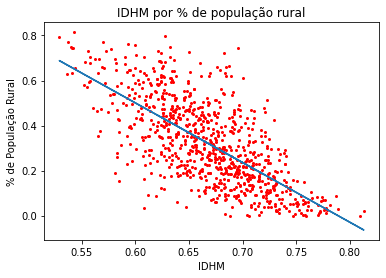

In [146]:
print("CORRELAÇÃO IDHM - POPULAÇÃO RURAL")
corr_altitude,pval=stats.pearsonr(df_altitudes['IDHM'],df_altitudes["Rural/Total"])
print(corr_altitude)
print(pval)
m,b = np.polyfit(df_altitudes['IDHM'], df_altitudes["Rural/Total"], deg=1)
plt.plot(df_altitudes['IDHM'], m*df_altitudes['IDHM'] + b)
plt.scatter(df_altitudes["IDHM"],df_altitudes["Rural/Total"], s=4, color='red')
plt.title("IDHM por % de população rural")
plt.xlabel('IDHM')
plt.ylabel('% de População Rural')
plt.show()